In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd

from template_sampling import *

In [2]:
import tensorflow.contrib.eager as tfe

In [3]:
tf.enable_eager_execution()

#### Import model, training function 

In [4]:
from annsa.model_classes import (DNN,
                                 CNN1D,
                                 save_model,
                                 train_earlystop)

#### Load DNN Easy

In [6]:
model_id='DNN-kfoldseasy-1_15_dae_features'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
model_features.output_function = None
        
DNNeasy_model = DNN(model_features)
DNNeasy_model.load_weights('../final_training_notebooks/final-models/DNN_onlinedataaugeasy_checkpoint_0')

#### Load DNN Full

In [9]:
model_id='DNN-kfoldsfull_20_dae_features'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
model_features.output_function = None
DNNfull_model = DNN(model_features)
DNNfull_model.load_weights('../final_training_notebooks/final-models/DNN_onlinedataaugfull_checkpoint_0')

#### Load CNN Easy

In [10]:
model_id='CNN-kfoldseasy_1'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)

CNN1Deasy_model = CNN1D(model_features)
CNN1Deasy_model.load_weights('../final_training_notebooks/final-models/CNN_onlinedataaugeasy_updates_checkpoint_0')

#### Load CNN Full

In [11]:
model_id='CNN-kfoldseasy_1'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
        
CNN1Dfull_model = CNN1D(model_features)
CNN1Dfull_model.load_weights('../final_training_notebooks/final-models/CNN_onlinedataaugeasy_updates_checkpoint_1')

### Load CNN and DNN trained with log-distributed counts

In [12]:
model_id='CNN-kfoldseasy_1'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
CNN1Deasy_model_log = CNN1D(model_features)
CNN1Deasy_model_log.load_weights('../final_training_notebooks/final-models/CNN_onlinedataaugeasy_updates_log10integrationtime_checkpoint_0')

In [13]:
model_id='CNN-kfoldseasy-1_8_dae_features'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)

CNN1Dfull_model_log = CNN1D(model_features)
CNN1Dfull_model_log.load_weights('../final_training_notebooks/final-models/CNN_onlinedataaugfull_log10integrationtime_checkpoint_0')

In [16]:
model_id='DNN-kfoldseasy-1_15_dae_features'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
model_features.output_function = None
DNNeasy_model_log = DNN(model_features)
DNNeasy_model_log.load_weights('../final_training_notebooks/final-models/DNN_onlinedataaugeasy_log10integrationtime_checkpoint_0')

In [17]:
model_id='DNN-kfoldsfull_20_dae_features'
with open('../hyperparameter_search/hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)
model_features.output_function = None
DNNfull_model_log = DNN(model_features)
DNNfull_model_log.load_weights('../final_training_notebooks/final-models/DNN_onlinedataaugfull_log10integrationtime_checkpoint_0')

### Compare integration time and calibration changes in real spectra

In [18]:
from annsa import read_spectrum

In [19]:
def read_measured_spectra(isotope,
                          signal2background,
                          measured_spectra):

    for voltage_key in measured_spectra:
        for k in range(30): 
            test = read_spectrum('../training_testing_data/'+isotope+'_SB-'+signal2background+'/detector129_'+
                                 voltage_key+'_10s_'+isotope+'_'+'{:03d}'.format(k)+'.Spe')
            measured_spectra[voltage_key].append(test)
    
    return measured_spectra

In [20]:
all_spectra = {}

In [21]:


for isotope in ['co60', 'eu152', 'cs137']:
    measured_spectra = {'720v' : [],
                    '745v' : [],
                    '770v' : [],
                    '795v' : [],
                    '820v' : [],
                   }
    all_spectra[isotope+'_1'] = read_measured_spectra(isotope = isotope,
                                                  signal2background = '1.0',
                                                  measured_spectra = measured_spectra)
    measured_spectra = {'720v' : [],
                        '745v' : [],
                        '770v' : [],
                        '795v' : [],
                        '820v' : [],
                       }
    all_spectra[isotope+'_05'] = read_measured_spectra(isotope = isotope,
                                    signal2background = '0.5',
                                    measured_spectra = measured_spectra)

isotope = 'ba133'
measured_spectra = {'720v' : [],
                    '745v' : [],
                    '770v' : [],
                    '795v' : [],
                    '820v' : [],
                   }
all_spectra[isotope+'_1'] = read_measured_spectra(isotope = isotope,
                                signal2background = '1.0',
                                measured_spectra = measured_spectra)
measured_spectra = {'720v' : [],
                    '745v' : [],
                    '770v' : [],
                    '820v' : [],
                   }
all_spectra[isotope+'_05'] = read_measured_spectra(isotope = isotope,
                                signal2background = '0.5',
                                measured_spectra = measured_spectra)

In [43]:
from template_sampling import rebin_spectrum

In [44]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [45]:
def rebin_spectrum(spectrum_template, a=0, b=1, c=0):
    '''
    Rebins spectrum based on quadratic rebinning.  Returns a 1024 channel spectrum.

    inputs:
        spectrum_template : vector (1x1194)
            The spectrums template
        a : float
            Constant rebinning term
        b : float
            Linear rebinning term
        c : float
            Quadratic rebinning term
    returns:
        rebinned_spectrum_template : vector (1x1194)
            The rebinned spectrum template
    '''

    new_bin_positions = a + b*np.arange(1024) + c*np.arange(1024)**2

    spectrum_template = griddata(np.arange(1024),
                                 spectrum_template,
                                 new_bin_positions,
                                 method='cubic',
                                 fill_value=0.0)
    spectrum_template[spectrum_template < 0] = 0
    return spectrum_template[:1024]

## create binarizer

In [161]:

source_dataset = pd.read_csv('../../source-interdiction/training_testing_data/shielded_templates_200kev_dataset.csv')


all_keys = source_dataset['isotope'].values

mlb=LabelBinarizer()
all_keys_binarized = mlb.fit_transform(all_keys.reshape([all_keys.shape[0],1]))

CNN1Deasy_model_log
['60CO']
CNN1Dfull_model_log
['238U']
DNNeasy_model_log
['60CO']
DNNfull_model_log
['60CO']


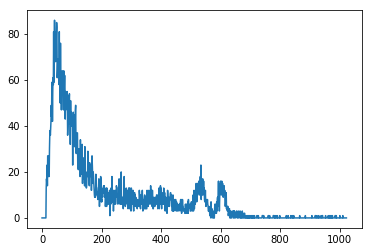

In [633]:
test_spec = read_spectrum('../training_testing_data/Co60_20cm.Spe')
test_spec = rebin_spectrum(test_spec,a=0.0,b=0.8,c=0.0)
test_spec[0:10] = 0
test_spec = test_spec/np.sum(test_spec)
test_spec *= 1e4
test_spec = np.random.poisson(test_spec)
plt.plot(test_spec)

model = CNN1Deasy_model_log
print('CNN1Deasy_model_log')
print(mlb.inverse_transform(model.forward_pass([test_spec],training=False).numpy()))

model = CNN1Dfull_model_log
print('CNN1Dfull_model_log')
print(mlb.inverse_transform(model.forward_pass([test_spec],training=False).numpy()))

model = DNNeasy_model_log
print('DNNeasy_model_log')
print(mlb.inverse_transform(model.forward_pass([test_spec],training=False).numpy()[0]))

model = DNNfull_model_log
print('DNNfull_model_log')
print(mlb.inverse_transform(model.forward_pass([test_spec],training=False).numpy()[0]))


In [ ]:
720v
745v
770v
795v
820v

In [634]:
isotope = 'eu152'
signal2background = '05'
voltage_setting = '770v'


spectrum_rebinned = np.cumsum([rebin_spectrum(spec,a=0.0,b=1.0,c=0.0) for spec in all_spectra[isotope+'_'+signal2background][voltage_setting]],axis=0)

print(mlb.inverse_transform((CNN1Deasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)))
print(mlb.inverse_transform((CNN1Dfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)))
print(mlb.inverse_transform((DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)))
print(mlb.inverse_transform((DNNfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)))

['152EU' '152EU' '60CO' '60CO' '60CO' '60CO' '60CO' '60CO' '60CO' '152EU'
 '152EU' '152EU' '152EU' '60CO' '152EU' '60CO' '152EU' '152EU' '152EU'
 '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU'
 '152EU' '152EU']
['60CO' '60CO' '60CO' '152EU' '60CO' '152EU' '152EU' '152EU' '152EU'
 '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU'
 '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU' '177MLU'
 '177MLU' '177MLU' '177MLU' '177MLU' '177MLU']
['99MO' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU'
 '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU'
 '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU' '152EU'
 '152EU' '152EU' '152EU']
['99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO'
 '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO'
 '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO' '99MO']


<Figure size 720x360 with 0 Axes>

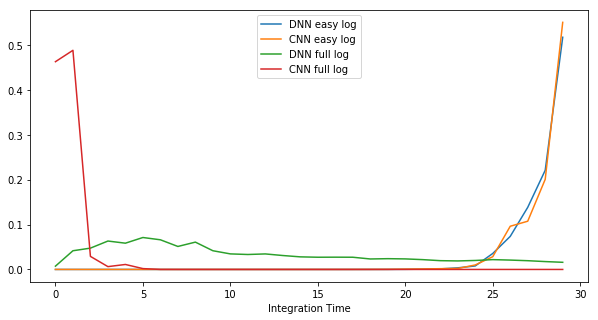

In [636]:
plt.figure(figsize=(10,5))

#plt.plot(softmax(DNNeasy_model.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'DNN Easy')
#plt.plot(softmax(DNNfull_model.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'DNN Full')

#plt.plot(softmax(CNN1Deasy_model.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'CNN Easy')
#plt.plot(softmax(CNN1Dfull_model.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'CNN Full')

plt.plot(softmax(DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'DNN easy log')
plt.plot(softmax(CNN1Deasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'CNN easy log')
plt.plot(softmax(DNNfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'DNN full log')
plt.plot(softmax(CNN1Dfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30)[:,24], label = 'CNN full log')


# spectrum_rebinned = np.cumsum([rebin_spectrum(spec,a=0.0,b=1.0,c=0.005) for spec in measured_spectra['820v']],axis=0)

plt.xlabel('Integration Time')
plt.legend()

In [651]:
DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy().reshape(30,30)[1]

array([ -8.29506759, -18.49234593,  -7.95927147, -16.06321371,
         1.39857893, -22.38373674, -25.10825311,   7.34292871,
        14.38898287, -20.07167785, -14.97177701, -13.4658005 ,
       -15.42158251, -16.91899272,   1.52695107, -28.24334101,
       -10.1150272 , -22.81670412, -17.30836351, -20.84622648,
       -12.58228165, -18.50045425,  -8.87953018,  -6.16588856,
         8.16558199, -19.0499366 ,  -1.03024496,  12.7260075 ,
        -6.49796099,   3.71553201])

In [669]:
np.max(softmax(DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1)

array([0.9999746 , 0.72607143, 0.1141655 , 0.04329585, 0.03707715,
       0.02559713, 0.03620172, 0.03193049, 0.03020811, 0.03412252,
       0.0273562 , 0.02589161, 0.02456614, 0.02600169, 0.02782001,
       0.0218718 , 0.02021963, 0.01889834, 0.01990636, 0.01999601,
       0.02084127, 0.02428563, 0.05701158, 0.06346412, 0.08102927,
       0.09487298, 0.11231738, 0.14606558, 0.3691371 , 0.6182426 ])

In [677]:
np.sort(softmax(DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=0)

array([[9.15886728e-14, 2.07913304e-35, 2.91172059e-17, 6.86354726e-20,
        1.79544282e-03, 3.29578036e-35, 6.92585759e-30, 4.30169386e-14,
        3.68052114e-23, 2.45980637e-27, 3.32601842e-26, 4.94956543e-22,
        6.40319911e-22, 7.10100135e-19, 1.93682958e-09, 1.05357024e-42,
        7.40606579e-21, 1.39850124e-31, 1.41948333e-21, 3.73901130e-32,
        1.07467478e-16, 4.62046720e-21, 5.92180204e-15, 3.56628720e-08,
        1.88889980e-22, 1.02997370e-32, 4.95627663e-08, 2.94165287e-11,
        5.32629090e-13, 1.88267212e-02],
       [1.49453272e-13, 9.14602596e-35, 8.27829507e-17, 1.45713259e-19,
        2.12413347e-03, 1.12579069e-34, 2.10314077e-29, 5.31633554e-13,
        1.24613263e-19, 7.91448285e-27, 8.50252605e-26, 9.99267285e-22,
        1.56233755e-21, 1.34117840e-18, 1.61657793e-08, 5.78180830e-42,
        2.15865121e-20, 4.76460481e-31, 3.36090617e-21, 1.49527706e-31,
        2.20887970e-16, 1.00272928e-20, 1.14332739e-14, 6.19915458e-08,
        1.47854806e-18,

In [683]:
[x[-2] for x in np.sort(softmax(DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1)]


[0.9999680688252576,
 0.37014059321479664,
 0.07616132917792726,
 0.015588548057945918,
 0.008495644081982851,
 0.003922909448233943,
 0.0019998972313526025,
 0.00480344587880925,
 0.003367321117231414,
 0.0031956789401235593,
 0.004025183420589869,
 0.0028511411290868477,
 0.003174075839255985,
 0.0029120988018683154,
 0.004528405213546196,
 0.003546540971053186,
 0.005351342728143779,
 0.006674464376084873,
 0.01127086512489436,
 0.016380795808875945,
 0.01882672124425344,
 0.019118236836260263,
 0.01998704981587521,
 0.021853002011039985,
 0.03617559823347272,
 0.06926974426753596,
 0.0982222245514462,
 0.13842650027775089,
 0.26165577663236095,
 0.517580950117227]

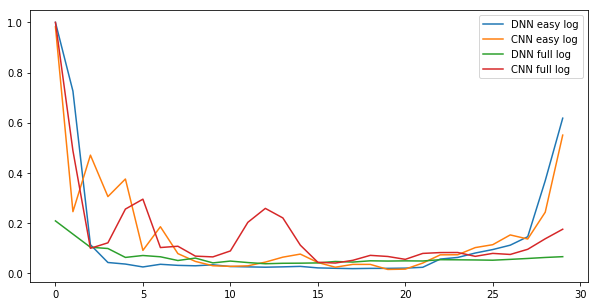

In [658]:
plt.figure(figsize=(10,5))

plt.plot(np.max(softmax(DNNeasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1), label = 'DNN easy log')
plt.plot(np.max(softmax(CNN1Deasy_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1), label = 'CNN easy log')
plt.plot(np.max(softmax(DNNfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1), label = 'DNN full log')
plt.plot(np.max(softmax(CNN1Dfull_model_log.forward_pass(spectrum_rebinned,training=False).numpy()).reshape(30,30),axis=1), label = 'CNN full log')
plt.legend()